In [2]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import matplotlib.colors 
import tqdm
import scipy.signal
import statsmodels.tsa.stattools

In [3]:
#define time interval, T should be integer
T = 10000

def mu(t):
    return 2/T * t - 1

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))

In [4]:
def get_equilibria_paths():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[2.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[-2.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,ts[i]),(0.0,50),[0.0], method="BDF")
        unstable[i] = sol.y[0,-1]
     
    unstable[np.abs(unstable)>1] = np.nan

    return ts,upper,lower,unstable


In [5]:
ts,upper,lower,unstable = get_equilibria_paths()

  4%|▎         | 367/10001 [00:41<18:01,  8.90it/s]


KeyboardInterrupt: 

In [ ]:
true_ls = 1 - upper**2
window_length = 200 

In [ ]:
#numerical simulation of SDEs:

steps_per_unit_time = 10                                           
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
# xs_white[0] = 2.103803356099623
xs_white[0] = 2.07

sigma = 0.01
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time + 1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]



#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                           #upper[0]
kappa = 0.05                                                                    #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time + 1)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
xs_red_filtered = xs_red[::steps_per_unit_time]

eta_filtered = eta[::steps_per_unit_time]


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:01<00:00, 68813.06it/s]


In [ ]:
#version with var and ar over several time units

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    n_windows = int(T/window_length) 
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
#x should have size T*steps_per_unit_time + 1
    n_windows = int(T/window_length) 
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar


In [62]:
statsmodels.tsa.stattools.acf([0,1,3,2])[1]

0.1499999999999999

In [77]:
x = np.array([0,1,3,2])
a = np.mean(x)
np.dot(x[1:]-a,x[:-1]-a)/(np.sum((x-a)**2))

0.15

In [ ]:
#version with var and ar over several time units

variance_series_white = get_var(xs_white_filtered)
variance_series_red = get_var(xs_red_filtered)
ac_series_white = get_ar(xs_white_filtered)
ac_series_red = get_ar(xs_red_filtered)

100%|██████████| 50/50 [00:00<00:00, 2677.30it/s]


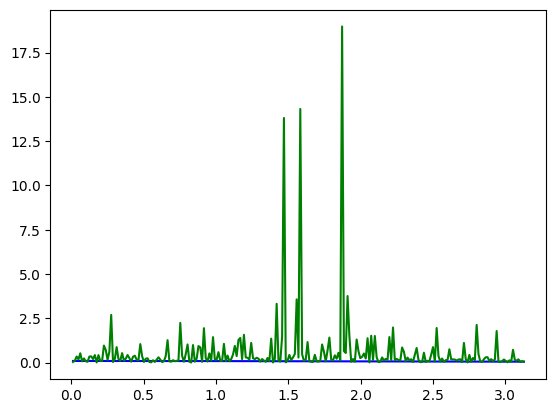

In [46]:
plt.plot(frequencies,targets, color = "blue")
plt.plot(frequencies,np.array(estim_psd_xs_wn)/np.array(estim_psd_xi_wn), color = "green")

In [35]:
upper[0]

2.1038036683718486

In [17]:
#numerical simulation of SDEs:

steps_per_unit_time = 10                                                        #to have smaller dt / Andreas multiplied f with 0.2      
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
xs_white[0] = upper[0]

sigma = 0.01
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time + 1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + 0.2*f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]                                  #0.2 is new



#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = upper[0]                                                         #upper[0]
kappa = 0.05                                                                    #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time + 1)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

eta = eta(1)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + 0.2*f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
xs_red_filtered = xs_red[::steps_per_unit_time]




100%|██████████| 100000/100000 [00:00<00:00, 283846.17it/s]


In [18]:
white_noise_filtered = np.array([np.sum([white_noise[i*steps_per_unit_time+j] for j in range(steps_per_unit_time)]) for i in range(T)])
# white_noise_filtered = white_noise[::steps_per_unit_time]
red_noise_filtered = np.array([np.sum([eta[i*steps_per_unit_time+j]*dt for j in range(steps_per_unit_time)]) for i in range(T)]) #why does it not work?
eta_filtered = eta[::steps_per_unit_time]

In [95]:
#get_lambda verstehen
#vorfaktor sqrt kürzt sich

xs_white_filt_detr = statsmodels.tsa.tsatools.detrend(xs_white_filtered[:1000],order = 2)

mean_ls_500 = true_ls[:1000].mean()*0.2

frequencies = 2*np.pi*(1/1000)*np.arange(1,500)

targets = 1/(frequencies**2 + mean_ls_500**2)
estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(1000)*(np.exp(-1j*frequencies[i]*np.arange(0,1000)) @ xs_white_filt_detr))**2 for i in range(499)])
estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(1000)*(np.exp(-1j*frequencies[i]*np.arange(0,1000)) @ (white_noise_filtered[:1000]*sigma)))**2 for i in range(499)])

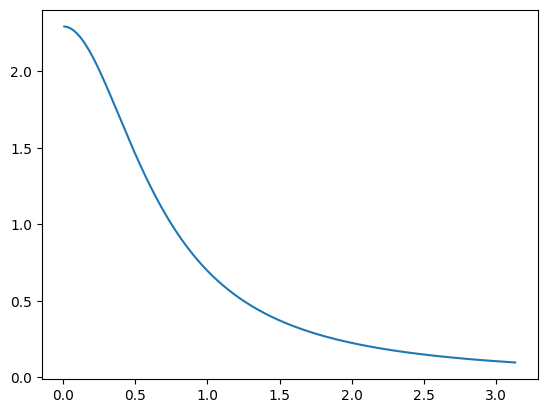

In [131]:
plt.plot(frequencies,targets)
# plt.xscale('log')
# plt.yscale('log')
# plt.yscale('log')

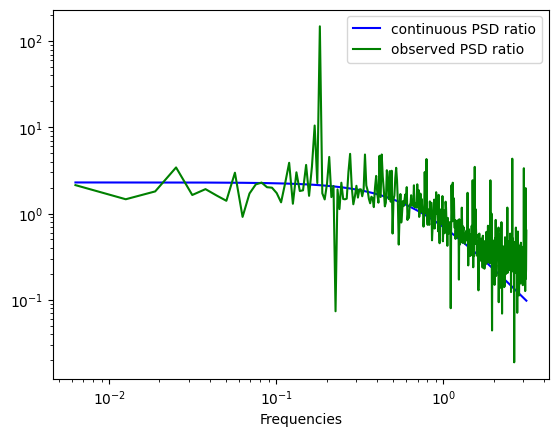

In [96]:
plt.plot(frequencies,(targets), color = "blue",label='continuous PSD ratio')
plt.plot(frequencies,(np.array(estim_psd_xs_wn)/np.array(estim_psd_xi_wn)), color = "green",label='observed PSD ratio')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequencies')
plt.legend()

In [12]:
#ls version without convolution

def get_ls(x,noise,a):

    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)

    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[i]*np.arange(0,window_length)) @ (noise_window*a)))**2 for i in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                  frequencies, 
                                                  np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls


In [20]:
ls_white = get_ls(xs_white_filtered,white_noise_filtered,sigma)
ls_red = get_ls(xs_red_filtered,red_noise_filtered,kappa)                         #try with sum and mean

100%|██████████| 50/50 [00:00<00:00, 145.70it/s]


In [154]:
#ls version with convolution

def get_ls_c(x,noise,a,conv_length):

    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)

    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[i]*np.arange(0,window_length)) @ (noise_window*a)))**2 for i in range(int(window_length/2) - 1)])

        observed_psd_conv = np.convolve(estim_psd_xs_wn/estim_psd_xi_wn,np.ones(conv_length)/conv_length,"valid")      #log conv or conv(log)?

        popt = scipy.optimize.curve_fit(fitfunction,
                                                  frequencies[:-conv_length + 1], 
                                                  np.log(observed_psd_conv),
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls

In [155]:
ls_white_c = get_ls_c(xs_white_filtered,white_noise_filtered,sigma,20)
ls_red_c = get_ls_c(xs_red_filtered,eta_filtered,kappa,20)

100%|██████████| 50/50 [00:00<00:00, 139.74it/s]


Text(0.5, 0, '$\\mu(t)$')

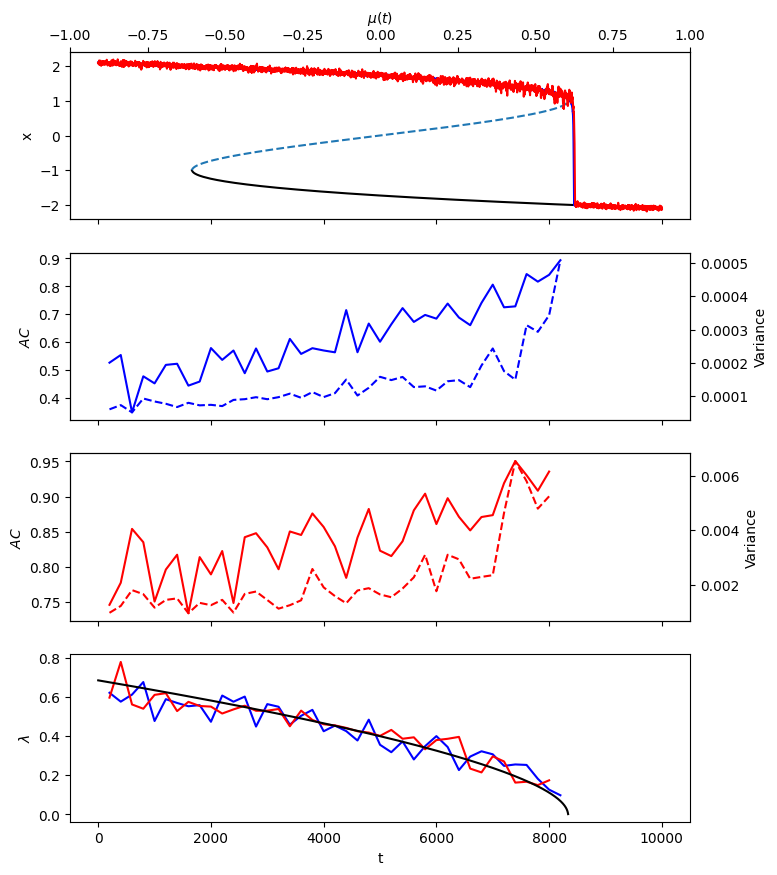

In [21]:
#why is lambda estimation so far from true lambda?, how to choose fs in ls method?


tipp_upper = np.argmin(upper>1)
tipp_lower = np.argmin(lower>-1)


tip_white = np.argmin(xs_white_filtered>1.0)
tip_red = np.argmin(xs_red_filtered>1.0)  


fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts[:tipp_upper],upper[:tipp_upper],color = "black")
axs[0].plot(ts[tipp_lower:],lower[tipp_lower:],color = "black")
axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
axs[0].plot(ts,xs_white_filtered,color="blue")
axs[0].plot(ts,xs_red_filtered,color="red")


axs[1].plot(ts[window_length:tip_white:window_length],ac_series_white[:int(tip_white/window_length)],color="blue")                               
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length:tip_white:window_length],variance_series_white[:int(tip_white/window_length)],color="blue",linestyle="--")


axs[2].plot(ts[window_length:tip_red:window_length],ac_series_red[:int(tip_red/window_length)],color="red")
ax2_var = axs[2].twinx()
ax2_var.plot(ts[window_length:tip_red:window_length],variance_series_red[:int(tip_red/window_length)],color="red",linestyle="--")


axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
axs[2].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")
ax2_var.set_ylabel(r"Variance")



axs[3].set_xlabel("t")    
axs[3].plot(ts[window_length:tip_white:window_length],ls_white[:int(tip_white/window_length)],color="blue")
axs[3].plot(ts[window_length:tip_red:window_length],ls_red[:int(tip_red/window_length)],color="red")
axs[3].plot(ts[:tipp_upper],-0.2*true_ls[:tipp_upper],color="black")
axs[3].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel(r"$\mu(t)$")

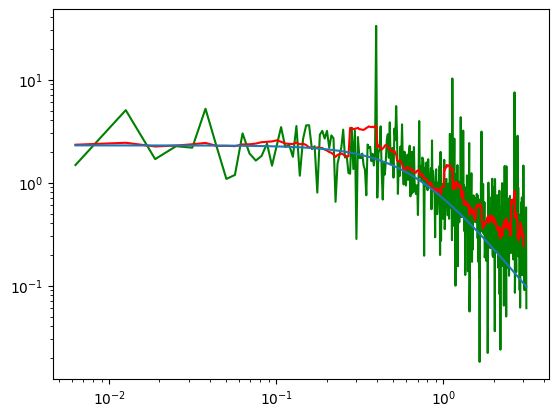

In [151]:
conv_length = 20
observed_psd = estim_psd_xs_wn/estim_psd_xi_wn
plt.loglog(frequencies,observed_psd, color = "green")

plt.loglog(frequencies[:-conv_length+1],np.array(np.convolve(observed_psd,np.ones(conv_length)/conv_length,"valid")), color = "red")
plt.loglog(frequencies,targets)

In [33]:
#show spurious EWS var, ac for increasing kappa and decreasing theta

#linear ramp for kappa
def kappa(t,k0,kT):
    return (1-t/T)*k0 + t/T*kT

#linear ramp for theta
def theta(t,th0,thT):
    return (1-t/T)*th0 + t/T*thT


In [69]:
ls_0 = true_ls[0]
ls_0

-3.4259898750548476

In [56]:
#numerical simulation of SDEs:

steps_per_unit_time = 10                                                        #to have smaller dt / Andreas multiplied f with 0.2      
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time


#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                           #upper[0]
k0 = 0.05
kT = 0.1
th0 = 1
thT = 0.5                                                                    #shouldn't be too small 

def eta():
    eta = np.zeros(T*steps_per_unit_time + 1)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta(solve_ts[i],th0,thT)*dt)*eta[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT))*(1-np.exp(-2*theta(solve_ts[i],th0,thT)*dt)))*np.random.normal(0,1)
    return eta

eta = eta()


for i in tqdm.trange(T*steps_per_unit_time):
    xs_red[i+1] = xs_red[i] + ls_0*xs_red[i]*dt + kappa(solve_ts[i],k0,kT)*eta[i]*dt



xs_red_filtered = xs_red[::steps_per_unit_time]

# white_noise_filtered = white_noise[::steps_per_unit_time]
eta_filtered = eta[::steps_per_unit_time]


  0%|          | 0/99999 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 501862.28it/s]


In [60]:
#version with var and ar over several time units

variance_series_red = get_var(xs_red_filtered)
ac_series_red = get_ar(xs_red_filtered)

100%|██████████| 50/50 [00:00<00:00, 2770.53it/s]


In [40]:
#ls version without convolution, flexible parameter for kappa

def get_ls_k(x,noise):


    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)

    
    b = max(k0,kT)
    a = min(k0,kT)
    d = (b-a)/n_windows

    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]

        k = b - d*(i+0.5)
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[i]*np.arange(0,window_length)) @ (noise_window*k)))**2 for i in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                  frequencies, 
                                                  np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls


In [61]:
ls_red_k = get_ls_k(xs_red_filtered,eta_filtered)

100%|██████████| 50/50 [00:00<00:00, 150.14it/s]


In [1]:
plt.plot(ts[1:],xs_red_filtered[1:])

NameError: name 'plt' is not defined

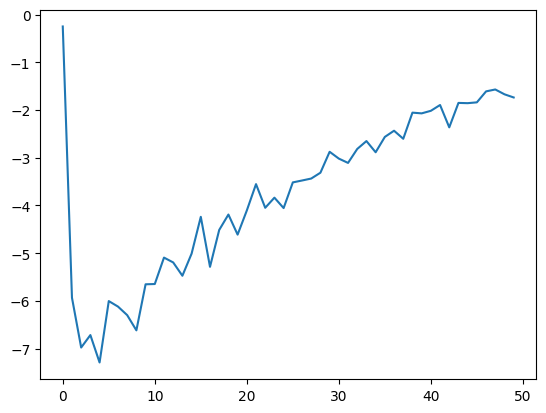

In [67]:
plt.plot(np.arange(50),-ls_red_k)

Text(0.5, 0, 'mu')

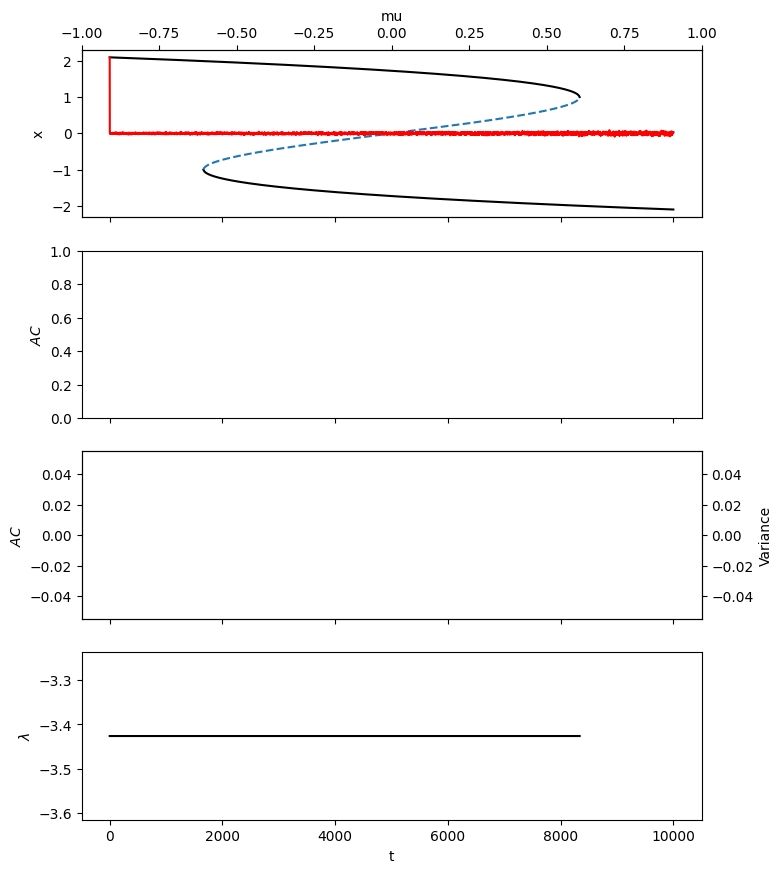

In [63]:
#why is lambda estimation so far from true lambda?, how to choose fs in ls method?


# tipp_upper = np.argmin(upper>1)
# tipp_lower = np.argmin(lower>-1)


# tip_red = np.argmin(xs_red_filtered>1.0)  


fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(8,10)) 

# axs[0].plot(ts[:tipp_upper],upper[:tipp_upper],color = "black")
# axs[0].plot(ts[tipp_lower:],lower[tipp_lower:],color = "black")
# axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
# axs[0].plot(ts,xs_red_filtered,color="red")



axs[2].plot(ts[window_length:tip_red:window_length],ac_series_red[:int(tip_red/window_length)],color="red")
ax2_var = axs[2].twinx()
ax2_var.plot(ts[window_length:tip_red:window_length],variance_series_red[:int(tip_red/window_length)],color="red",linestyle="--")


axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
axs[2].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")
ax2_var.set_ylabel(r"Variance")



axs[3].set_xlabel("t")    
axs[3].plot(ts[window_length:tip_red:window_length],-ls_red_k[:int(tip_red/window_length)],color="red")
axs[3].plot(ts[:tipp_upper],np.full_like(ts[:tipp_upper],ls_0),color="black")      #before: 0.2*true_ls[:tipp_upper]
axs[3].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel("mu")